# Анализ покупательской активности клиентов интернет-магазина

У нас есть данные о клиентах интернет-магазина. На основе этих данным мы обучим модель, которая будет предсказывать покупательскую активность клиента (снизилась ли она или осталась на прежнем уровне). Это поможет персонализировать предложения для постоянных клиентов, чтобы удержать их активность.

[Знакомство с данными](#section_id1)

[Предобработка данных](#section_id2)

[Исследовательский анализ](#section_id3)

[Объединение таблиц](#section_id4)

[Корреляционный анализ](#section_id5)

[Использование пайплайнов](#section_id6)

[Анализ важности признаков](#section_id7)

[Сегментация покупателей](#section_id8)

[Вывод](#section_id9)

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import RandomizedSearchCV

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

#объявляем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

<a id='section_id1'></a>
## Знакомство с данными

In [2]:
#функция для вывода информации о таблице
def data_info(data):
    display(data.head())
    data.info()

In [3]:
market_file = pd.read_csv("/market_file.csv")
market_money = pd.read_csv("/market_money.csv")
market_time = pd.read_csv("/market_time.csv")
money = pd.read_csv("/money.csv", sep = ';', decimal=',')

### market_file

In [4]:
data_info(market_file)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:
 - id — номер покупателя в корпоративной базе данных.
 - Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
 - Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
 - Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
 - Маркет_актив 6 мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
 - Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
 - Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
 - Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
 - Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
 - Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
 - Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
 - Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
 - Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Данные загружены корректно, таблица совпадает с описанием. Имеем 1300 строк, пропусков нет.

### market_money

In [5]:
data_info(market_money)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:
 - id — номер покупателя в корпоративной базе данных.
 - Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
 - Выручка — сумма выручки за период.

Данные прочитаны корректно, таблица совпадает с описанием. Имеем 3900 строк, пропусков нет.

### market_time

In [6]:
data_info(market_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
 - id — номер покупателя в корпоративной базе данных:
 - Период — название периода, во время которого зафиксировано общее время.
 - минут — значение времени, проведённого на сайте, в минутах.


Данные прочитаны корректно, таблица совпадает с описанием. Имеем 2600 строк, пропусков нет.

### money

In [7]:
data_info(money)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца:
 - id — номер покупателя в корпоративной базе данных.
 - Прибыль — значение прибыли.

Данные загружены корректно, таблица совпадает с описанием. Имеем 1300 строк, пропусков нет. Количество строк совпадает с таблицей market_file.

На данном шаге мы познакомились с данными. У нас четыре таблицы с информацией о пользователях интернет-магазина. Таблицы корректно загружены, пропусков нет, приступим к предобработке данных.

<a id='section_id2'></a>
## Предобработка данных

На предыдущем шаге мы узнали, что пропусков нет.

In [8]:
market_file.nunique() #проверим уникальные значения в таблице market_file

id                                     1300
Покупательская активность                 2
Тип сервиса                               3
Разрешить сообщать                        2
Маркет_актив_6_мес                       41
Маркет_актив_тек_мес                      3
Длительность                            658
Акционные_покупки                        42
Популярная_категория                      6
Средний_просмотр_категорий_за_визит       6
Неоплаченные_продукты_штук_квартал       11
Ошибка_сервиса                           10
Страниц_за_визит                         20
dtype: int64

In [9]:
#уберем пробелы в названиях столбцов для упрощения работы
#приведем наименования к нижнему регистру
market_file = market_file.rename(columns={"Покупательская активность": "покупательская_активность", 
                            "Тип сервиса": "тип_сервиса",
                           "Разрешить сообщать": "разрешить_сообщать"})
market_file = market_file.rename(columns=lambda x: x.lower())

market_file['тип_сервиса'].unique() #посмотрим на уникальные значение в стоблце тип сервиса

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [10]:
#удалим ошибку ввода
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace({'стандартт': 'стандарт'})

market_file.nunique() #проверим изменения

id                                     1300
покупательская_активность                 2
тип_сервиса                               2
разрешить_сообщать                        2
маркет_актив_6_мес                       41
маркет_актив_тек_мес                      3
длительность                            658
акционные_покупки                        42
популярная_категория                      6
средний_просмотр_категорий_за_визит       6
неоплаченные_продукты_штук_квартал       11
ошибка_сервиса                           10
страниц_за_визит                         20
dtype: int64

In [11]:
market_money.nunique() #проверим значения в market_money

id         1300
Период        3
Выручка    2776
dtype: int64

In [12]:
market_money = market_money.rename(columns=lambda x: x.lower()) #приведем к нижнему регистру
market_money['период'].unique() #посмотрим на уникальные значение в стоблце период

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [13]:
market_money.nunique() #проверим изменения

id         1300
период        3
выручка    2776
dtype: int64

In [14]:
market_time.nunique() #проверим значения в market_time

id        1300
Период       2
минут       20
dtype: int64

In [15]:
market_time = market_time.rename(columns={"Период": "период"}) #приведем в нижний регистр наименование стоблца

market_time['период'].unique() #посмотрим на уникальные значение в стоблце период

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [16]:
#исправим ошибку ввода данных
market_time['период'] = market_time['период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})
        
market_time.nunique() #проверим изменения

id        1300
период       2
минут       20
dtype: int64

In [17]:
money.nunique() #посмотрим на уникальные значение в таблице money

id         1300
Прибыль     400
dtype: int64

In [18]:
money = money.rename(columns={"Прибыль": "прибыль"}) #приведем в нижний регистр наименование стоблца

money.nunique() #проверим изменения

id         1300
прибыль     400
dtype: int64

Мы провели предобработку данных. Удалили ошибки ввода, переименовали столбцы. Узнали, что у нас в таблицах данные по 1300 клиентам.

<a id='section_id3'></a>
## Исследовательский анализ

### market_file

In [19]:
#функция для круговых диаграмм
def pies(data, column, axis):
    data.pivot_table(index=column, values='id', aggfunc='count').plot.pie(
          y='id', autopct='%1.1f%%', legend=False, title=column, ax=axis).set(ylabel='');
    
#фунция построения графиков для количественных параметров
def hist_boxplot(data, name):
    display(data[name].describe())
    f, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].hist(data[name]);
    ax[1].boxplot(data=data, x=data[name]);
    ax[0].set_title('Гистограмма распределения')
    ax[0].set_xlabel(name)
    ax[1].set_xlabel(name)
    ax[1].set_title('Распределение');

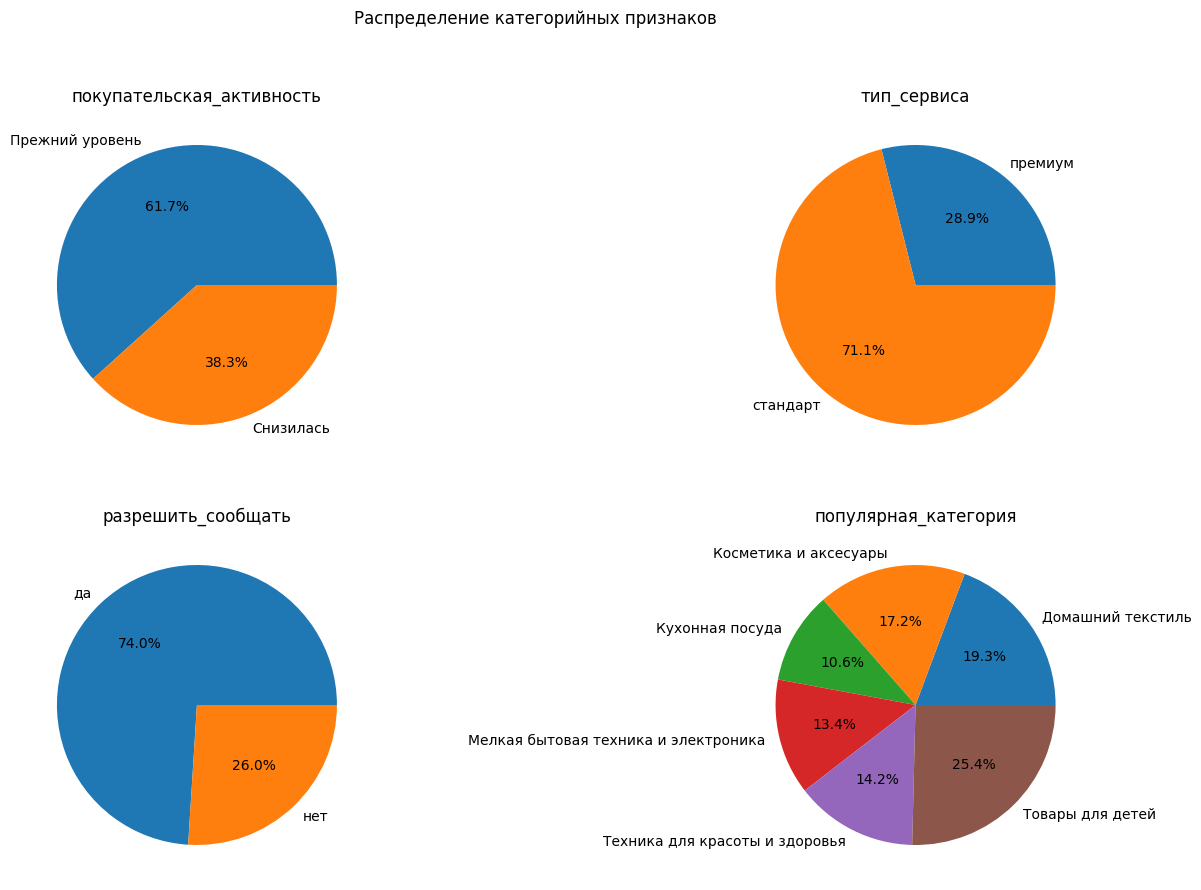

In [20]:
f, ax = plt.subplots(2, 2, figsize = (17,10))
f.suptitle('Распределение категорийных признаков')
pies(market_file, 'покупательская_активность', ax[0,0]);
pies(market_file, 'тип_сервиса', ax[0,1]);
pies(market_file, 'разрешить_сообщать', ax[1,0]);
pies(market_file, 'популярная_категория', ax[1,1]);

На диаграмме видно, что:
 - покупательская активность снизилась у 38,3% пользователей;
 - 71% пользователей пользуется стандартным типом сервиса;
 - 74% пользователей разрешили отправлять им сообщения;
 - У нас 6 популярных категорий товаров: *Товары для детей* (25%), *Домашний текстиль* (19%),  *Косметика и аксессуары* (17%), *Техника для красоты и здоровья* (14%), *Мелкая бытовая техника и электроника* (13%) и *Кухонная посуда* (11%). 

**Среднемесячное число маркетинговых контактов с клиентом**

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

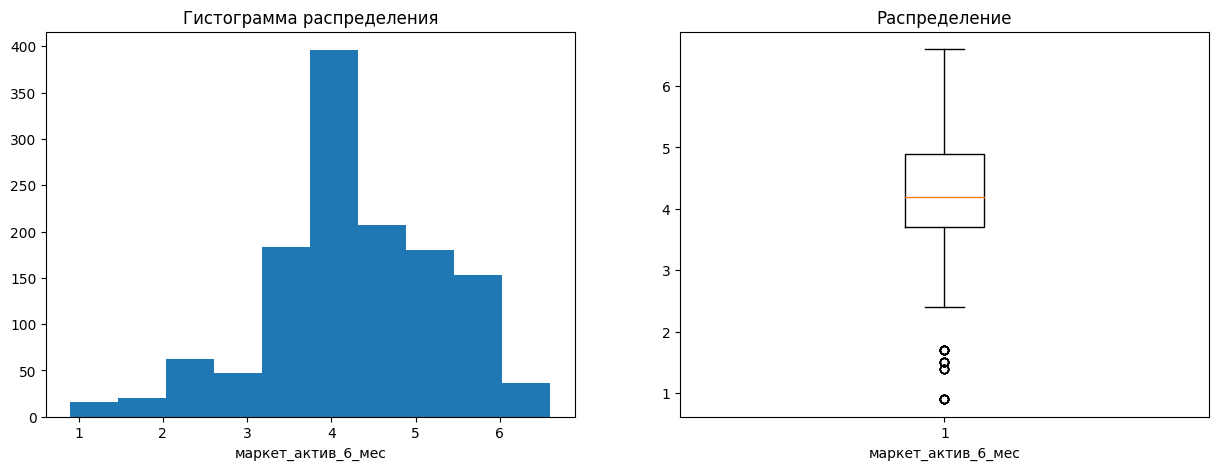

In [21]:
hist_boxplot(market_file, 'маркет_актив_6_мес'); #за последние 6 месяцев

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64

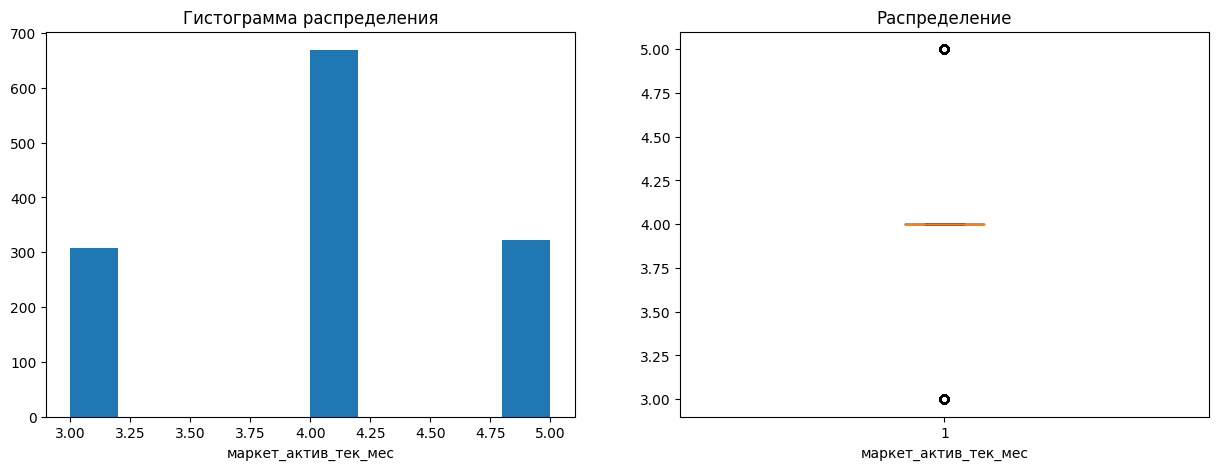

In [22]:
hist_boxplot(market_file, 'маркет_актив_тек_мес'); #в текущем месяце

В среднем 4 контакта в месяц приходятся на одного клиента.

**Длительность**

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

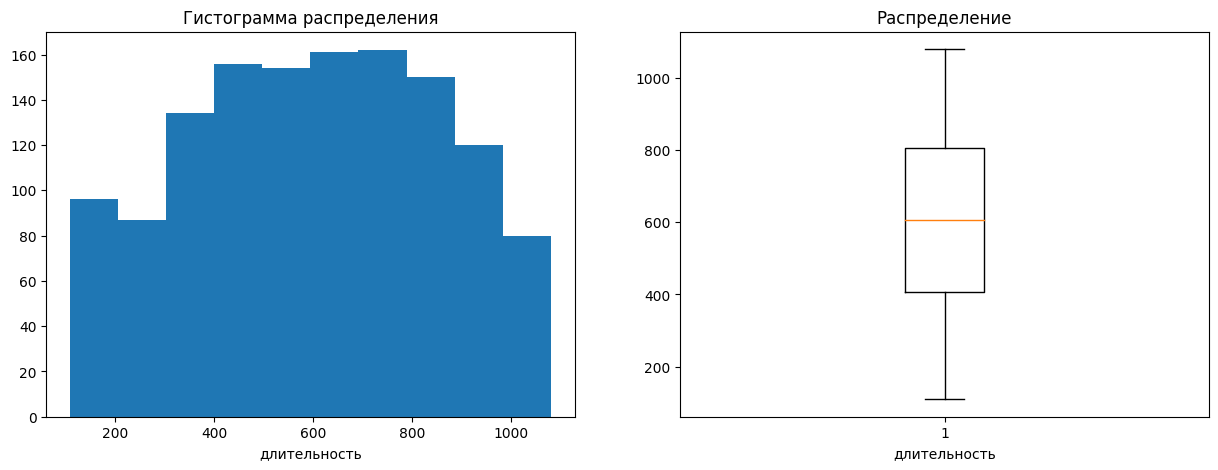

In [23]:
hist_boxplot(market_file, 'длительность'); 

В среднем пользователи зарегистрированы на сайте 600 дней. С момента регистрации прошло минимум 110 дней, максимум - 1079.

**Акционные покупки**

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

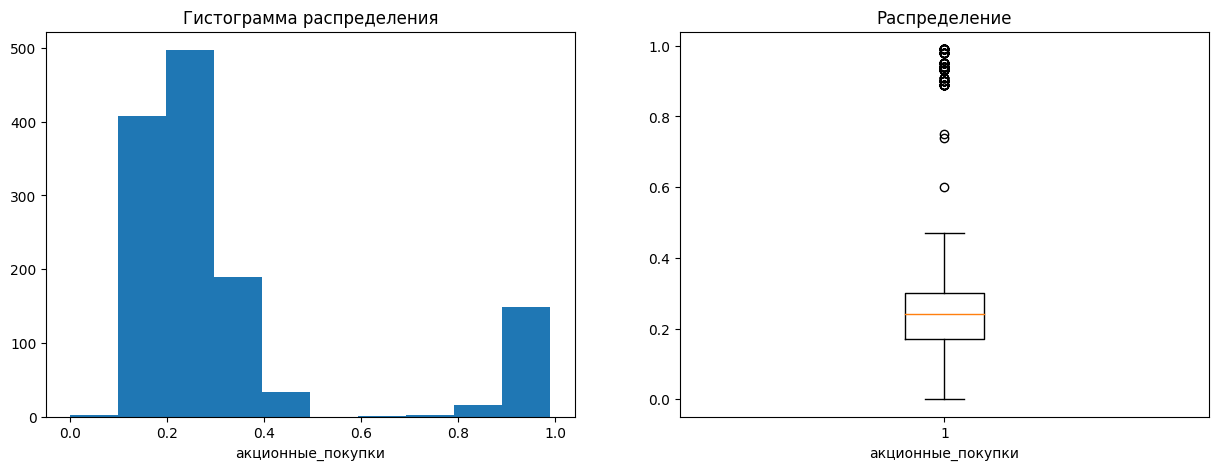

In [24]:
hist_boxplot(market_file, 'акционные_покупки'); 

In [25]:
market_file.query('акционные_покупки > 0.8')['акционные_покупки'].describe()

count    165.000000
mean       0.945091
std        0.031654
min        0.890000
25%        0.930000
50%        0.940000
75%        0.980000
max        0.990000
Name: акционные_покупки, dtype: float64

За последние 6 месяцев среднемесячная доля покупок по акции от общего числа покупок составляет 30%.

Есть клиенты (165), которые предпочитают покупать товары только со скидками (их покупки на 90% состоят из акционных товаров).

**Среднее количество просмотров категорий за визит**

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64

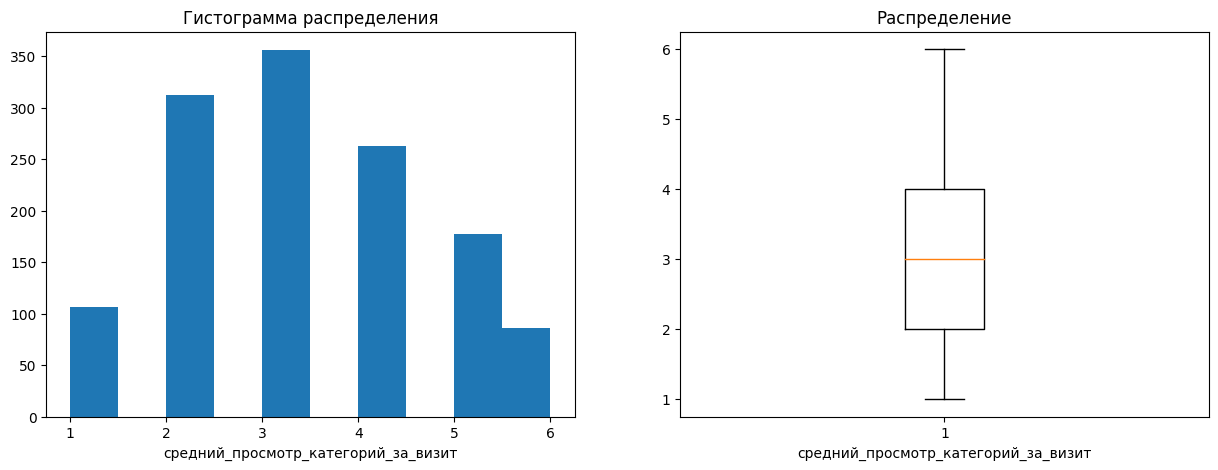

In [26]:
hist_boxplot(market_file, 'средний_просмотр_категорий_за_визит');

Видно нормальное распределение. В среднем клиенты просматривают 3 категории товаров за раз.

**Число неоплаченных товаров в корзине за последние 3 месяца**

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

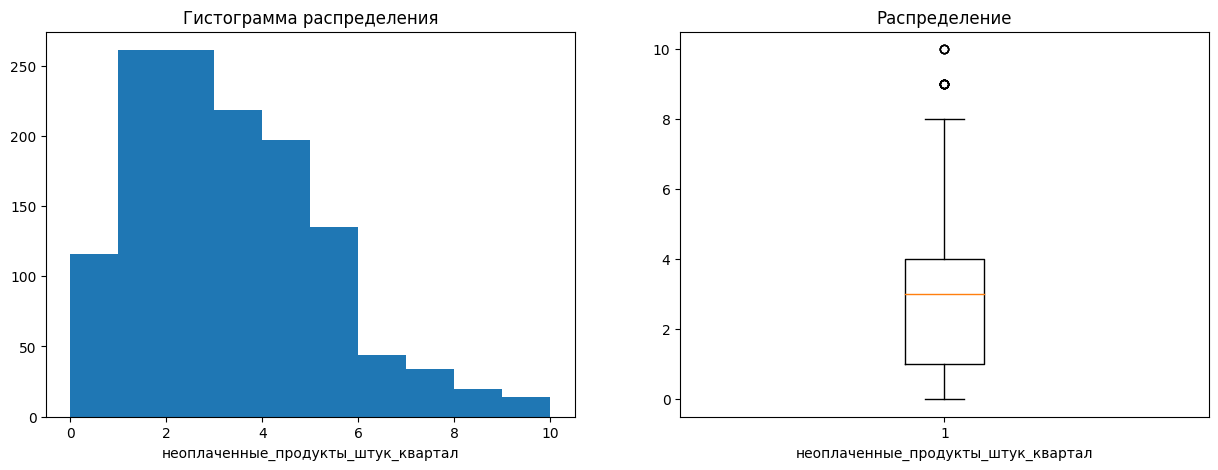

In [27]:
hist_boxplot(market_file, 'неоплаченные_продукты_штук_квартал');

10 неоплаченных товаров в корзине - максимум. В среднем у пользователей в корзине лежит 3 товара.

**Число сбоев сервиса, которое коснулось покупателей**

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

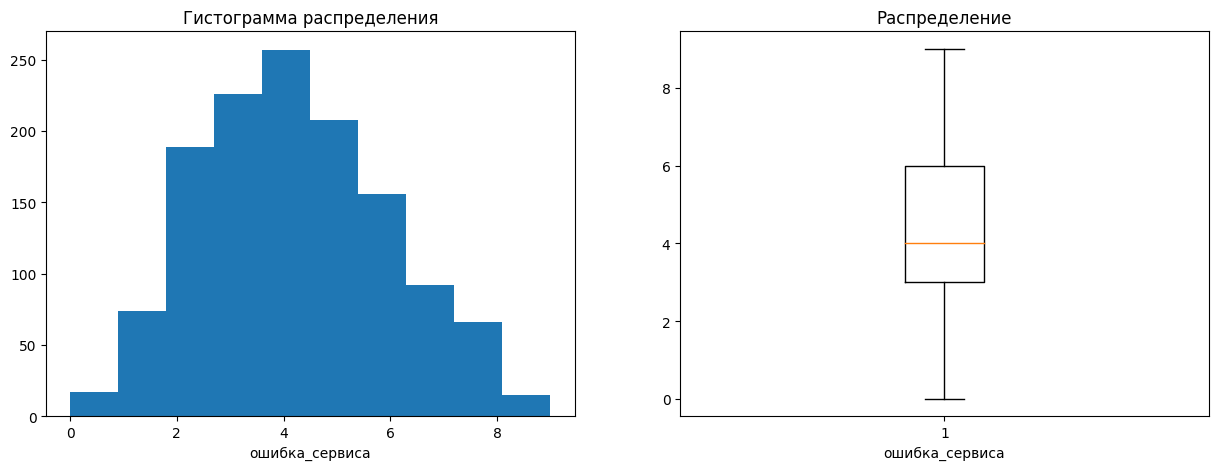

In [28]:
hist_boxplot(market_file, 'ошибка_сервиса');

Видим нормальное распределение. У самых невезучих сервис сбойнул 9 раз. В среднем у пользователей было 4 ошибки сервиса.

**Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца**

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

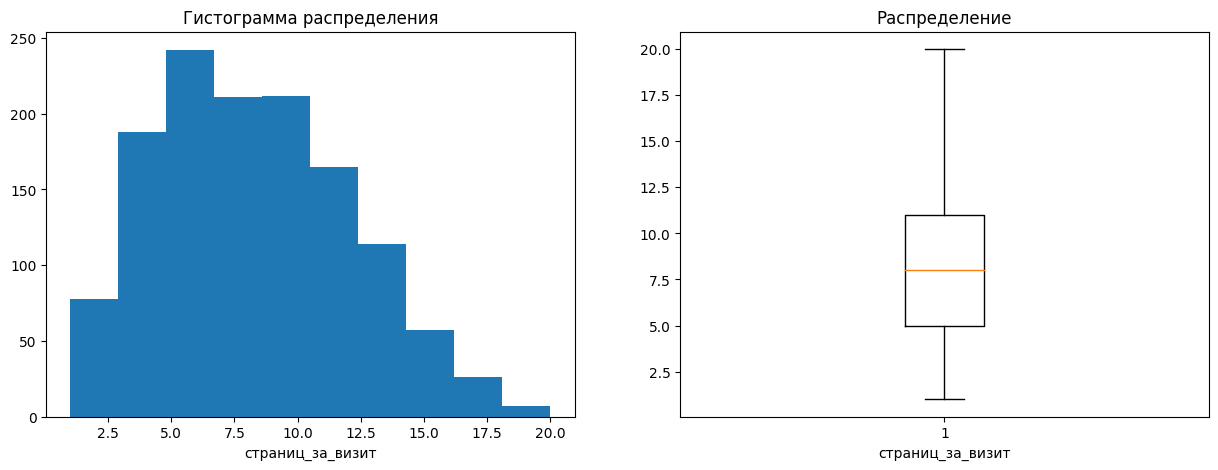

In [29]:
hist_boxplot(market_file, 'страниц_за_визит');

За раз пользователи просматривают от 1 до 20 страниц. В среднем 8 страниц за один заход.

### market_money

In [30]:
market_money['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

In [31]:
#заметен выброс
market_money.sort_values('выручка').tail()

,id,период,выручка
2388,216144,текущий_месяц,7547.8
1481,215841,текущий_месяц,7557.0
262,215435,текущий_месяц,7605.3
435,215493,текущий_месяц,7799.4
98,215380,текущий_месяц,106862.2


In [32]:
#посмотрим данные по id=215380 во всех таблицах
market_file.query('id == 215380')

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


In [33]:
market_money.query('id == 215380')

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


In [34]:
market_time.query('id == 215380')

,id,период,минут
64,215380,предыдущий_месяц,12
65,215380,текущий_месяц,14


Клиент активен, но данные нам говорят, что его покупательская активность в текущем месяце снизилась. Выручка в 106862 не вписывается в общую картину. Есть вероятность, что это число появилось из-за ошибки сервиса. Удалим данные о клиенте.

In [35]:
#функция для удаления клиента по id
def drop_by_id(id_name):
    for data in [market_file, market_money, market_time, money]:
        data.drop(data.query('id == @id_name').index, inplace=True)
        data.reset_index(drop=True, inplace=True)

In [36]:
drop_by_id(215380)

market_money['выручка'].describe() #проверим изменения

count    3897.000000
mean     4999.287760
std       706.970089
min         0.000000
25%      4590.000000
50%      4956.000000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64

count    1296.000000
mean     4836.202160
std       333.514091
min      4098.000000
25%      4584.500000
50%      4810.500000
75%      5056.000000
max      5663.000000
Name: выручка, dtype: float64

count    1296.000000
mean     4947.468750
std       700.797239
min      2890.000000
25%      4498.125000
50%      5005.500000
75%      5405.625000
max      6869.500000
Name: выручка, dtype: float64

count    1299.000000
mean     5236.787452
std       835.474686
min      2758.700000
25%      4705.500000
50%      5179.600000
75%      5759.950000
max      7799.400000
Name: выручка, dtype: float64

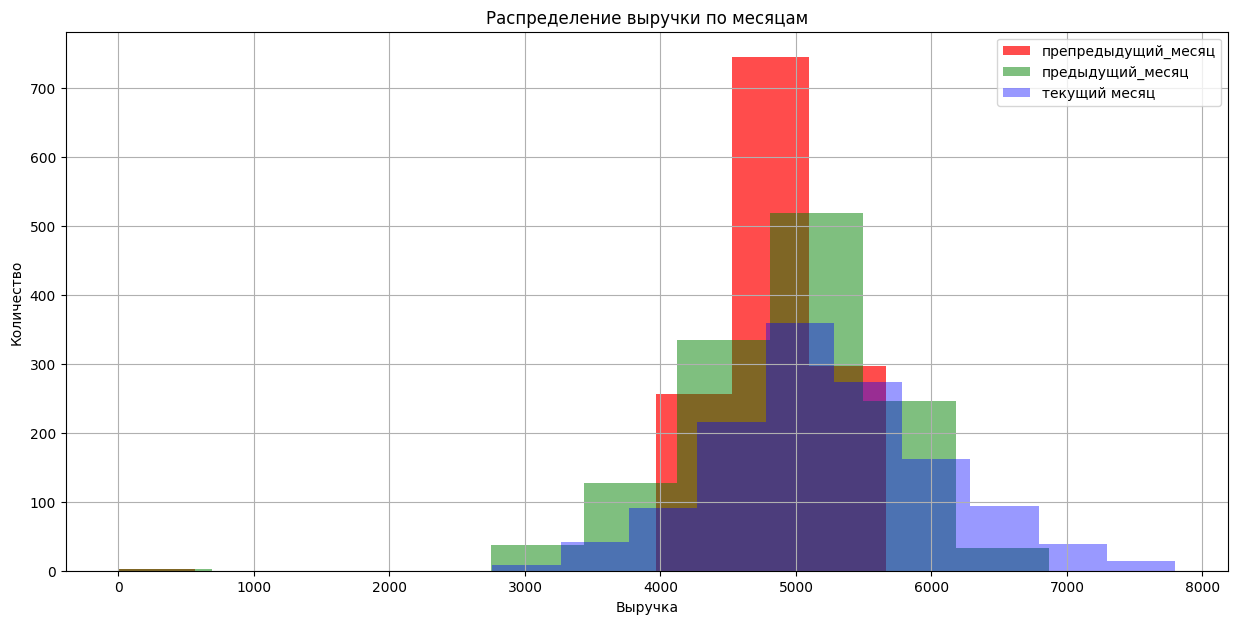

In [37]:
#построим гистограмму распределения выручки по месяцам
fig, ax = plt.subplots(figsize=(15,7))
market_money.query('период == "препредыдущий_месяц"')['выручка'].hist(ax=ax, alpha=0.7, color='red')
market_money.query('период == "предыдущий_месяц"')['выручка'].hist(ax=ax, alpha=0.5, color='green')
market_money.query('период == "текущий_месяц"')['выручка'].hist(ax=ax, alpha=0.4, color='blue')
lgnd = ax.legend(['препредыдущий_месяц', 'предыдущий_месяц', 'текущий месяц'], loc='upper right')
ax.set_xlabel('Выручка')
ax.set_ylabel('Количество')
ax.set_title('Распределение выручки по месяцам')
plt.show;
display(market_money.query('период== "препредыдущий_месяц" & выручка !=0')['выручка'].describe())
display(market_money.query('период== "предыдущий_месяц" & выручка !=0')['выручка'].describe())
display(market_money.query('период== "текущий_месяц" & выручка !=0')['выручка'].describe())

Видны нулевые значения выручки в каждом месяце. 

В препредыдущем месяце самая узкая вилка выручки от 4000 до 5700. Более 700 значений около 4800.

В предыдущем месяце выручка от 2800 до 6800. Пик в 5000.

В текущем месяце самый большой диапазон значений: от 2800 до 7800. Пик в 5000.

### market_time

count    1299.000000
mean       13.468822
std         3.933332
min         5.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        23.000000
Name: минут, dtype: float64

count    1299.000000
mean       13.204003
std         4.222157
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

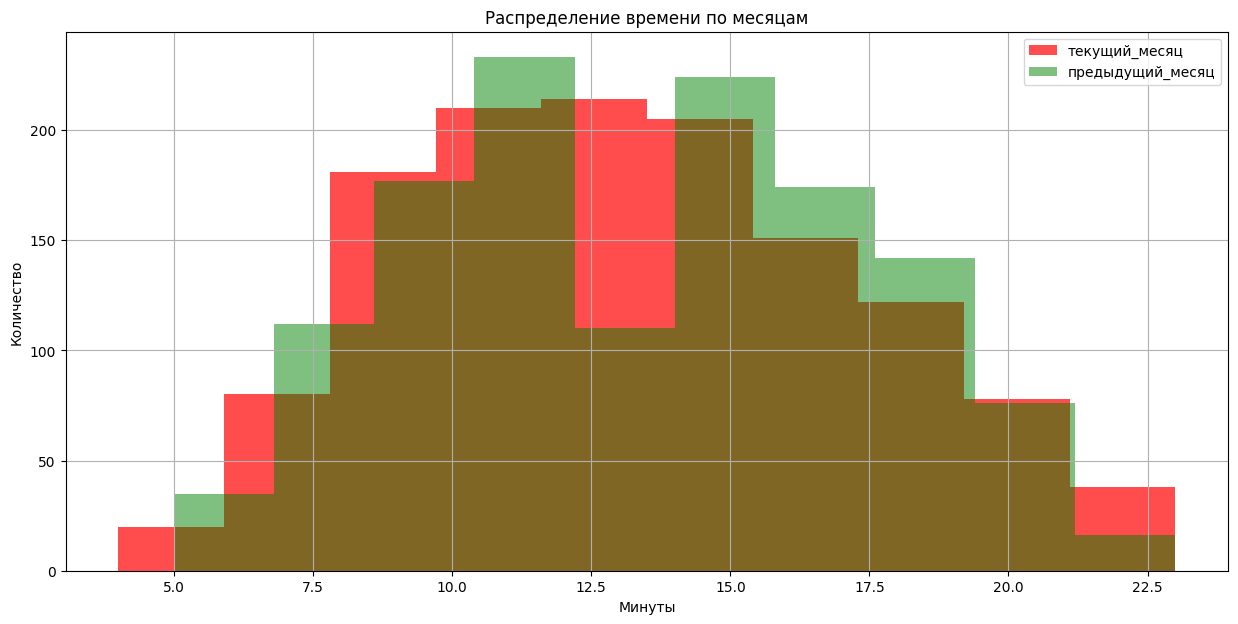

In [38]:
fig, ax = plt.subplots(figsize=(15,7))
market_time.query('период == "текущий_месяц"')['минут'].hist(ax=ax, alpha=0.7, color='red')
market_time.query('период == "предыдущий_месяц"')['минут'].hist(ax=ax, alpha=0.5, color='green')
lgnd = ax.legend(['текущий_месяц', 'предыдущий_месяц'], loc='upper right')
ax.set_xlabel('Минуты')
ax.set_ylabel('Количество')
ax.set_title('Распределение времени по месяцам')
plt.show;
display(market_time.query('период== "предыдущий_месяц"')['минут'].describe())
display(market_time.query('период== "текущий_месяц"')['минут'].describe())

Диапазон времени в текущем и предыдущем месяцах совпадают: от 4 до 23 минут. В текущем месяце распределение ближе к нормальному.

### money

count    1299.000000
mean        3.996721
std         1.014107
min         0.860000
25%         3.300000
50%         4.050000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

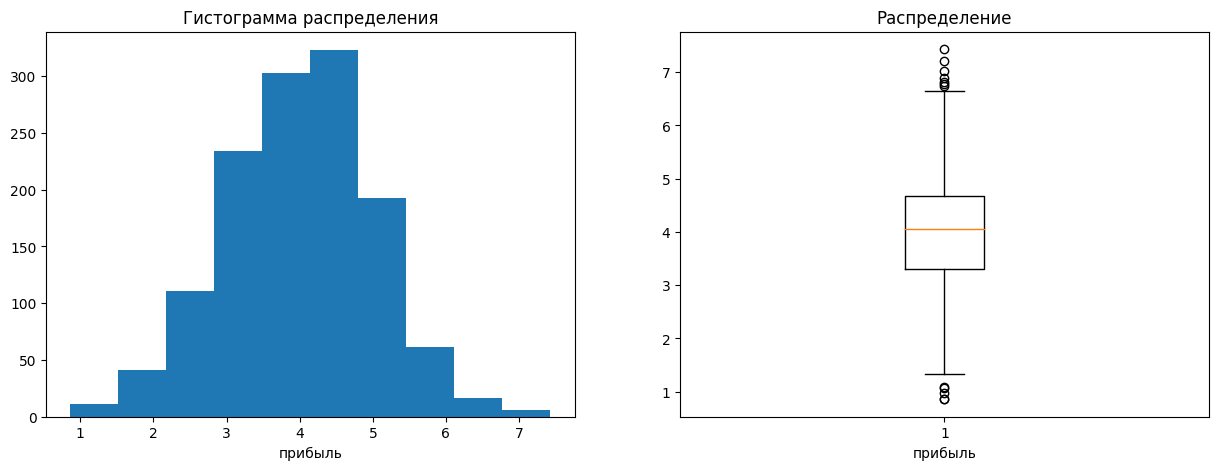

In [39]:
hist_boxplot(money, 'прибыль');

Прибыль распределена от 0.86 до 7.43. Среднее значение 4, распределение близко к нормальному.

### Отбор клиентов с покупательской активностью не менее трёх месяцев

In [40]:
market_money.query('выручка == 0')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


У нас есть три клиента, которые совершили покупки только в текущем месяце, два прошлых месяца они не были активны. Для дальнейшей работы они нам не подойдут, удалим их.

In [41]:
drop_by_id(215348)
drop_by_id(215357)
drop_by_id(215359)
market_money['выручка'].describe() #проверим изменения

count    3888.000000
mean     5007.255658
std       679.193461
min      2758.700000
25%      4591.950000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64

<div style="border:solid purple 1px; padding: 20px">
    
Мы удалили 4 клиентов, которые не подойдут нам для дальнейшей работы. Осталось 1296 пользователей.
    
На данном шаге мы узнали:
 - 62% пользователей остаются на прежнем уровне покупательской активности
 - 71% пользуется стандартным типом сервиса
 - 74% разрешили сообщения
 - топ-3 популярных категорий: *Товары для детей*, *Домашний текстиль*, *Косметика и аксессуары*
 - в среднем происходит 4 маркетенговых контакта в месяц
 - в среднем пользователи зарегистрированы на сайте 600 дней
 - в среднем у клиентов 30% покупок по акции за последние полгода
 - в среднем за визит просматривают 3 категории и 8 страниц
 - среднее число сбоев сервиса - 4
 - за три месяца в среднем в корзине у клиентов лежит 3 неоплаченных товара
 - средняя выручка немного растет за последние три месяца, диапазон значений увеличивается
 - время нахождения на сайте в предыдущем и текущем месяцах приблизительно одинаково

<a id='section_id4'></a>
## Объединение таблиц

In [42]:
#сводная таблица по market_money
market_money_new = market_money.pivot_table(index='id', values='выручка', columns='период')
market_money_new.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_new.head()

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


In [43]:
#сводная таблица по market_time
market_time_new = market_time.pivot_table(index='id', values='минут', columns='период')
market_time_new.columns = ['время_предыдущий_месяц', 'время_текущий_месяц']
market_time_new.head()

,время_предыдущий_месяц,время_текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10


In [44]:
#объединим таблицы
market_file.set_index('id', inplace=True)
market_file = market_file.join(market_money_new, how = 'left').join(market_time_new, how = 'left')
market_file.shape

(1296, 17)

На данном шаге мы объединили все данные о клиентах в одну таблицу. Получили 17 признаков.

<a id='section_id5'></a>
## Корреляционный анализ

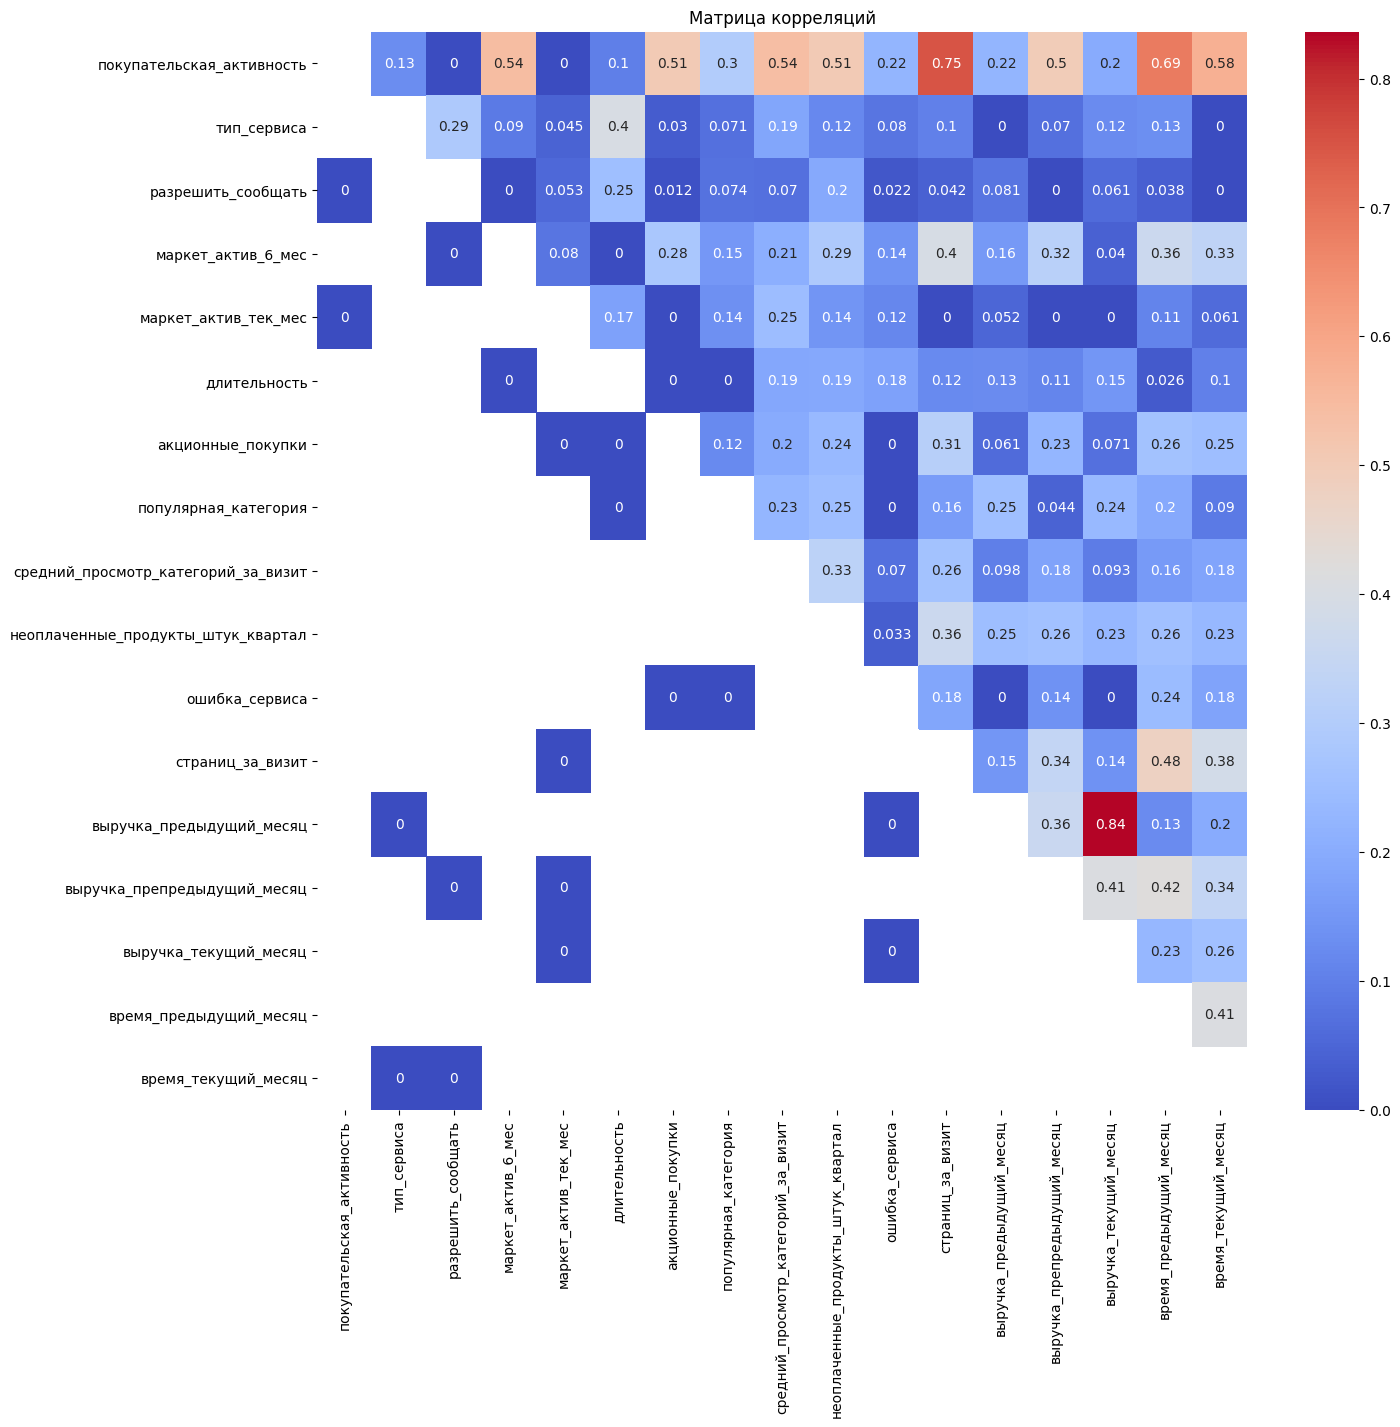

In [45]:
#посмотрим на матрицу корреляций всех признаков
#список количественных признаков
num_cols=['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
               'страниц_за_визит', 'выручка_предыдущий_месяц','выручка_препредыдущий_месяц', 
               'выручка_текущий_месяц', 'время_предыдущий_месяц', 'время_текущий_месяц']
mask = np.tril(market_file.phik_matrix(interval_cols=num_cols));
plt.figure(figsize=(15, 14))
sns.heatmap(market_file.phik_matrix(interval_cols=num_cols),
            annot=True, mask=mask, cmap='coolwarm');
plt.title('Матрица корреляций');
plt.show();

Видна корреляция 84% между выручкой за предыдущий месяц и выручкой за текущий, но коэффициент не высок, чтобы можно было говорить о мультиколлинеарности.

Видна зависимость целевого признака от количества просмотренных страниц за визит и времени проведенного на сайте.

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


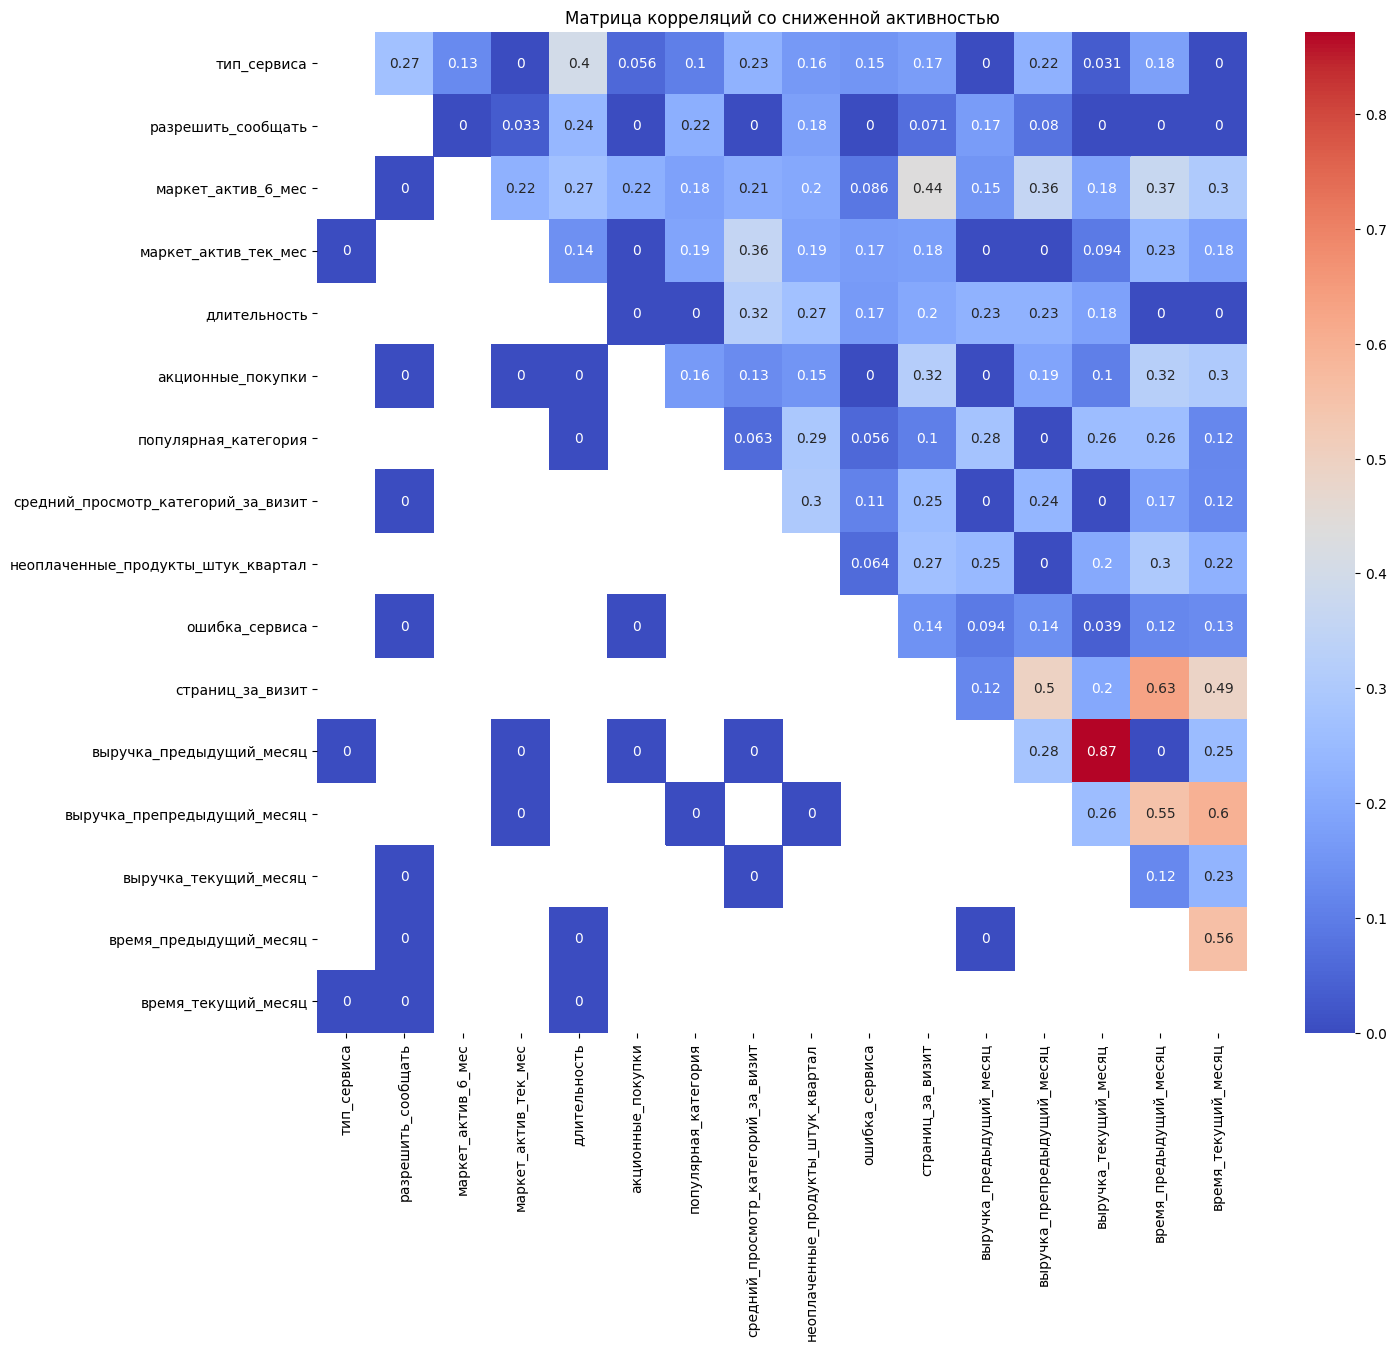

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


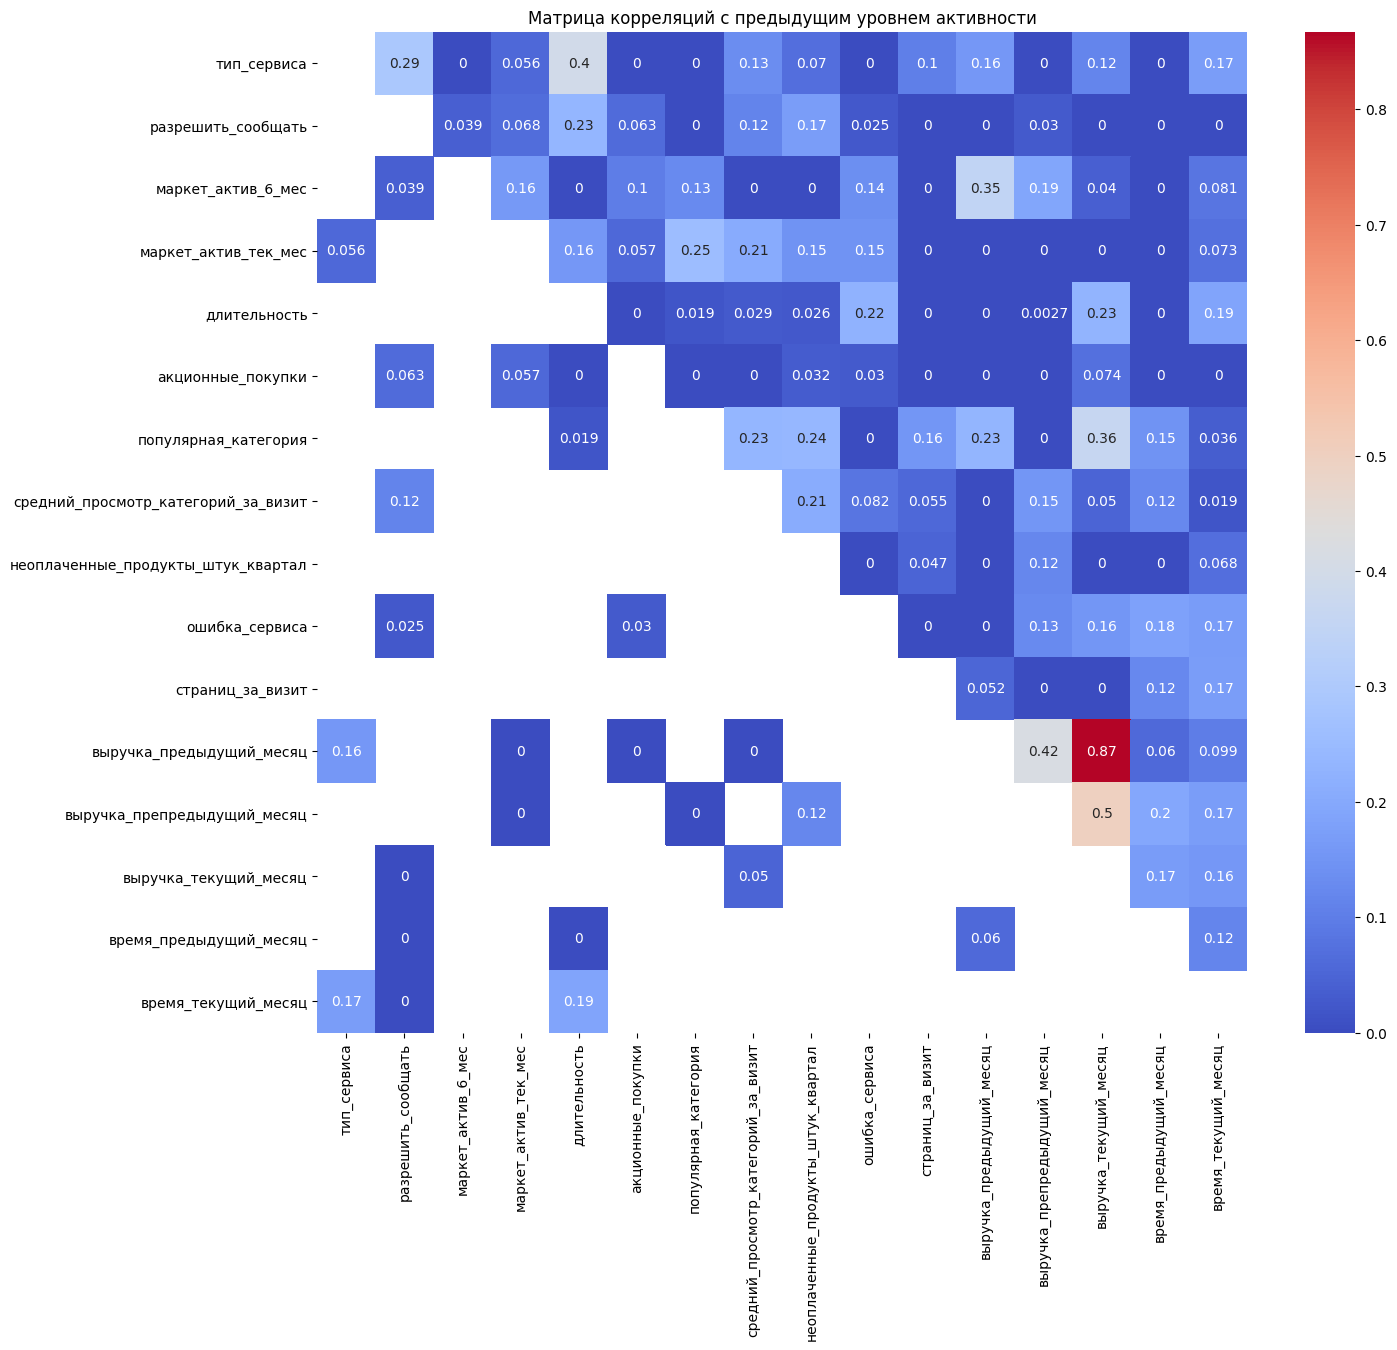

In [46]:
activity_low = market_file.query('покупательская_активность == "Снизилась"')
activity_norm = market_file.query('покупательская_активность == "Прежний уровень"')

mask = np.tril(activity_low.phik_matrix(interval_cols=num_cols));

plt.figure(figsize=(15, 13))
sns.heatmap(activity_low.phik_matrix(interval_cols=num_cols),
            annot=True, mask=mask, cmap='coolwarm');
plt.title('Матрица корреляций со сниженной активностью');
plt.show();

plt.figure(figsize=(15, 13))
sns.heatmap(activity_norm.phik_matrix(interval_cols=num_cols),
            annot=True, mask=mask, cmap='coolwarm');
plt.title('Матрица корреляций с предыдущим уровнем активности');
plt.show();

Мы построили две матрицы корреляций для каждого значения целевого признака.

Видна корреляция 87% между выручкой за предыдущий месяц и выручкой за текущий, но коэффициент не высок, чтобы можно было говорить о мультиколлинеарности.

В таблице со сниженной активностью заметны зависимости между временем на сайте, количеством просмотренных страниц и выручкой за позапрошлый месяц.

При этом в таблице со стабильной активностью много 0. Коэффициенты корреляций акционных покупок близки к 0. Аналогично с неоплаченными товарами в корзине.

Можно предположить, что в позапрошлом месяце были хорошие акции, и клиенты, которые привыкли брать товары со скидками, сейчас проводят больше времени на сайте в ожидании скидок, но ничего не покупают.

<a id='section_id6'></a>
## Использование пайплайнов

Для оценки работы модели возьмем метрику ROC-AUС, потому что целевой признак распределен не равномерно и для нас важна оценка качества работы модели в общем виде.

In [47]:
market_file.drop(['покупательская_активность'], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   тип_сервиса                          1296 non-null   object 
 1   разрешить_сообщать                   1296 non-null   object 
 2   маркет_актив_6_мес                   1296 non-null   float64
 3   маркет_актив_тек_мес                 1296 non-null   int64  
 4   длительность                         1296 non-null   int64  
 5   акционные_покупки                    1296 non-null   float64
 6   популярная_категория                 1296 non-null   object 
 7   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 8   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 9   ошибка_сервиса                       1296 non-null   int64  
 10  страниц_за_визит                     1296 non-null   int64  
 11  выручка_предыдущий_меся

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    market_file.drop(['покупательская_активность'], axis=1),
    market_file['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_file['покупательская_активность'])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test) 

#списки столбцов
ohe_cols = ['разрешить_сообщать', 'популярная_категория']
ord_cols = ['тип_сервиса']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first'))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', None, num_cols)
    ], 
    remainder='passthrough'
) 

pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', None)
])


param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC() 
    {
        'models': [SVC(
            random_state=RANDOM_STATE, 
            probability=True
        )],
         'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
         'models__degree' : range(2,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),...
                                  

Мы использовали пайплайн для поиска лучшей модели. Инструмент RandomizedSearchCV проверил работу 20 моделей и определил лучшую: SVC с метрикой ROC-AUC 90%.

<a id='section_id7'></a>
## Анализ важности признаков

  0%|          | 0/100 [00:00<?, ?it/s]

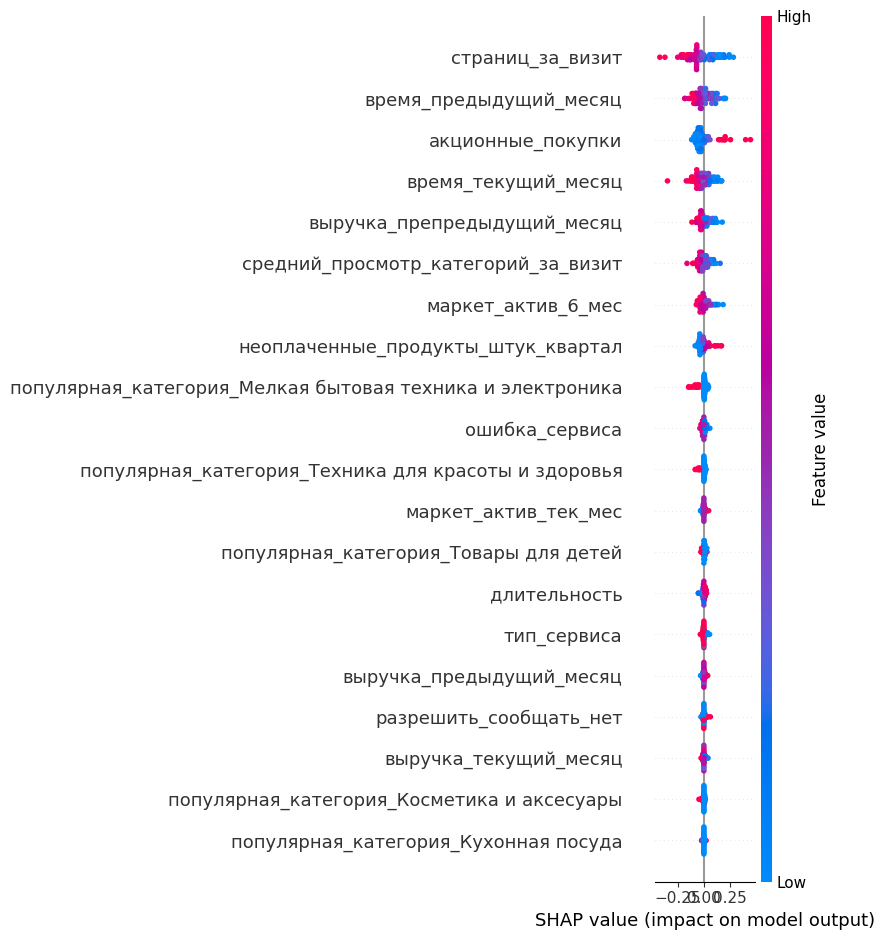

In [49]:
best_model = randomized_search.best_estimator_.named_steps['models']
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

ohe_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=ohe_cols)
all_feature_names = np.concatenate([ohe_names, ord_cols, num_cols])

X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

X_train_preprocessed_smp1 = shap.sample(X_train_preprocessed_df, random_state=RANDOM_STATE) 
X_test_preprocessed_smp1 = shap.sample(X_test_preprocessed_df, random_state=RANDOM_STATE)

explainer = shap.KernelExplainer(best_model.predict, X_train_preprocessed_smp1) 
shap_values = explainer.shap_values(X_test_preprocessed_smp1)

shap.summary_plot(shap_values, X_test_preprocessed_smp1)

Видно, что наиболее значимые признаки: время, проведенное на сайте, и количество просмотренных страниц. Чем больше человек тратит времени на сайте, тем меньше вероятность снижения его покупательской активности.

Важно значение количества покупок по акции. Если клиенты привыкли брать товары со скидками, то они не будут покупать за полную стоимость, и их покупательская активность будет падать. Возможно клиенты, добавившие товары в корзину, но не оплатившие их, ждут, когда появится скидка. Это тоже влияет на целевой признак.

Наименее значимые признаки: разрешение сообщений и тип сервиса. 

Маркетинговая активность не является значимым признаком. Значит, рассылка сообщений, писем и пуш-уведомлений не сильно помогут поддержать активность клиентов. Наиболее важно создать удобную навигацию по сайту. Нужно сделать так, чтобы клиенту было удобно просматривать страницы с товарами, переходить к другим товарам и видеть персональные предложения и акции.

<a id='section_id8'></a>
## Сегментация покупателей

Выберем сегмент покупателей, ориентируяcь на результаты работы модели и на прибыльность клиентов.

In [50]:
money.set_index('id', inplace=True) #установим id клиентов индексами
segment = X_test.join(money, how='left') #добавим в тестовую выборку данные о прибыльности
#добавим вероятности пренадлежности к классу "покупательская активность снизится", 
#которые выдает лучшая модель
segment['predict_proba'] = best_model.predict_proba(X_test_preprocessed_df)[:,1] 
segment.head()

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,прибыль,predict_proba
id,,,,,,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,4.69,0.031291
215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,2.75,0.978479
216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,3.16,0.121803
215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,3.74,0.895868
215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,4.40,0.611553


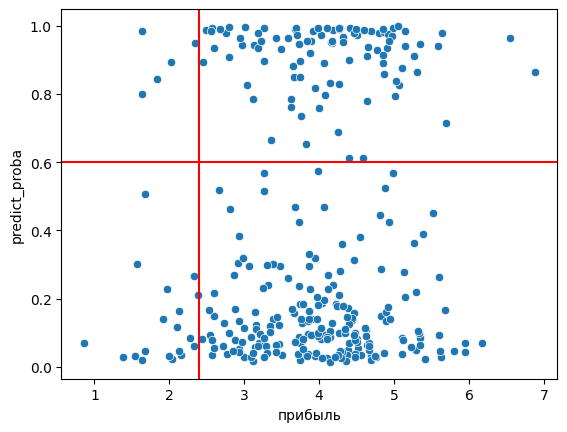

In [51]:
#пострим диаграмму рассеяния по признакам прибыль и predict_proba
sns.scatterplot(data = segment, x = 'прибыль', y = 'predict_proba');
plt.axvline(x=2.4, color='red');
plt.axhline(y=0.6, color='red');

Для дальнейшей работы возьмем сегмент пользователей, прибыль от которых больше 2.4 и вероятность принадлежности к классу "пользовательская активность снизится" больше 0.6.

In [52]:
segment = segment.query('(прибыль > 2.4)&(predict_proba>0.6)')
segment

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,прибыль,predict_proba
id,,,,,,,,,,,,,,,,,,
215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,2.75,0.978479
215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,3.74,0.895868
215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,4.40,0.611553
215844,премиум,да,4.3,4,1041,0.99,Кухонная посуда,4,1,6,6,5339.0,4880.0,5866.8,9,14,2.79,0.907312
215375,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,5253.5,4715.0,5633.1,8,9,4.18,0.987931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215651,стандарт,нет,2.4,3,715,0.40,Кухонная посуда,3,5,5,5,5109.5,4217.0,5498.2,10,8,5.15,0.984461
215397,стандарт,да,4.2,3,689,0.31,Домашний текстиль,4,2,2,3,4541.0,4430.0,5040.2,6,8,3.19,0.978478
215429,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4,3662.0,4488.0,4158.6,11,10,3.71,0.974368


Мы отобрали 99 пользователей.

Выберем из сегмента группу пользователей, которые чаще всего покупают товары по акции и хранят товары в корзине.

In [53]:
segment = segment.query('(акционные_покупки > 0.8)&(неоплаченные_продукты_штук_квартал > 0)')
segment.shape[0]

33

Мы получили 33 пользователей. Проведем анализ для данной выборки по важным для модели пареметрам, чтобы выделить способы увеличения покупательской активности.

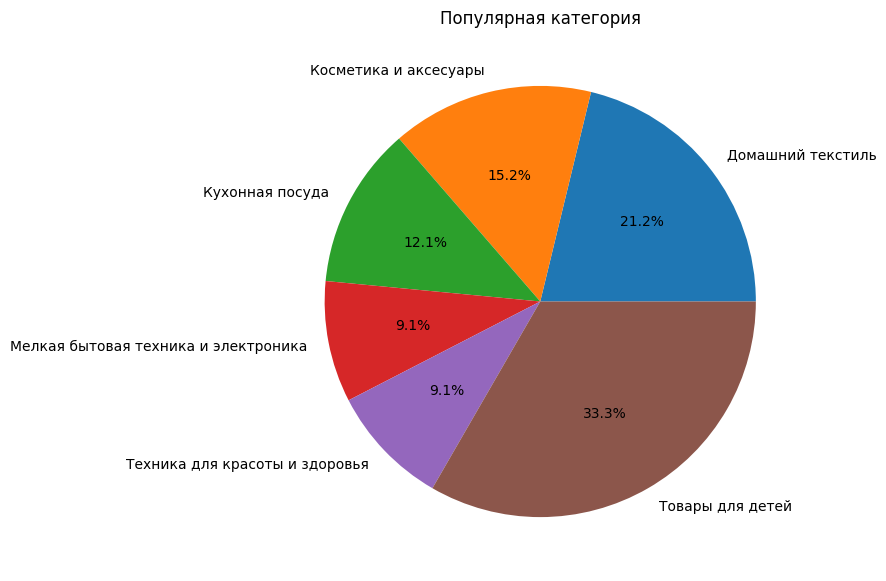

In [54]:
segment.pivot_table(index='популярная_категория', values='predict_proba', aggfunc='count').plot.pie(
          y='predict_proba', autopct='%1.1f%%', legend=False, title='Популярная категория', 
    figsize=(7,7)).set(ylabel='');

Больше трети товаров относятся к категории "Товары для детей". На втором месте "Домашний текстиль".

count    33.000000
mean      2.606061
std       1.116339
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64

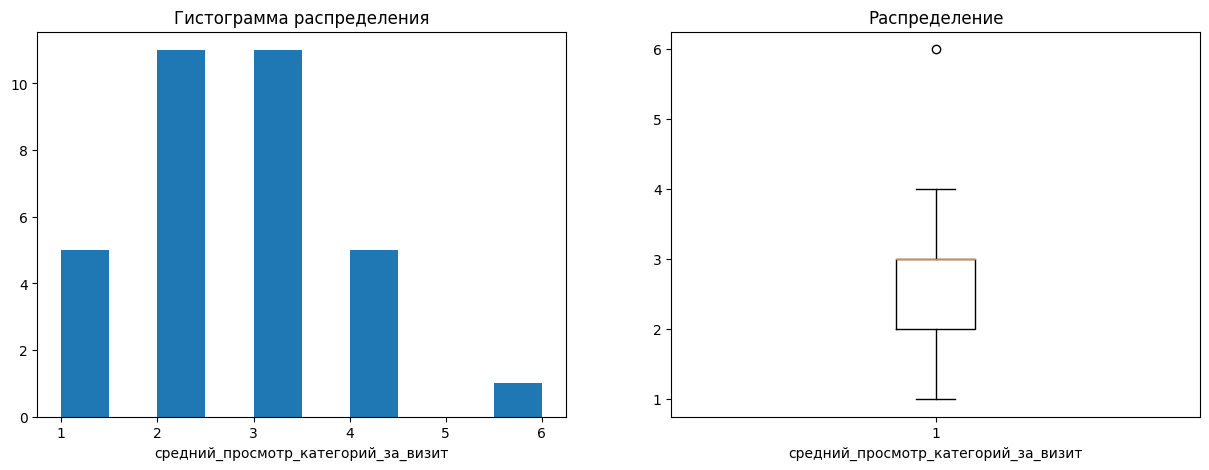

In [55]:
hist_boxplot(segment, 'средний_просмотр_категорий_за_визит');

В среднем клиенты просматривают две-три категории товаров за раз.

count    33.000000
mean      4.575758
std       1.837633
min       2.000000
25%       4.000000
50%       4.000000
75%       6.000000
max       9.000000
Name: страниц_за_визит, dtype: float64

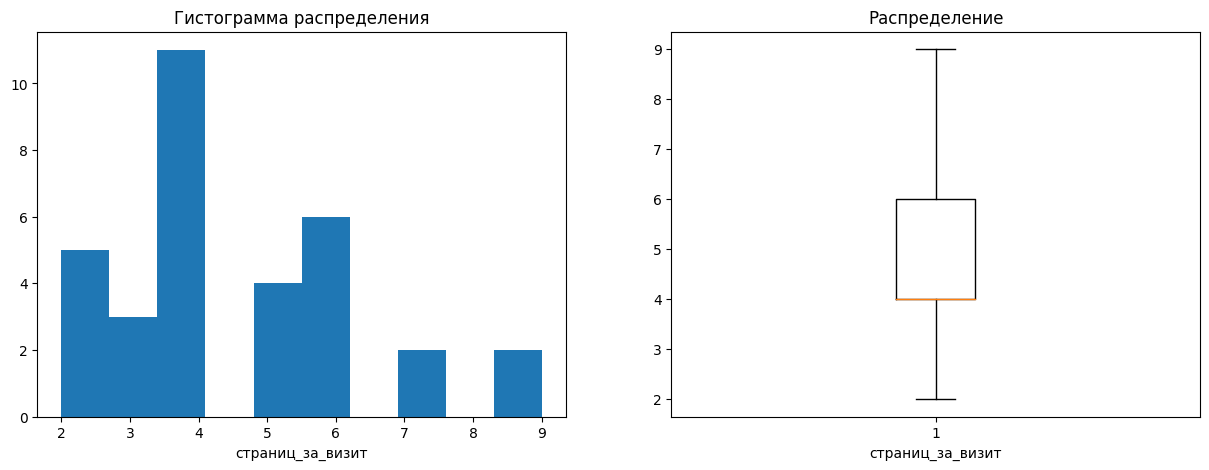

In [56]:
hist_boxplot(segment, 'страниц_за_визит');

В среднем пользователи просматривают 4 страницы за один раз, максимум 9 страниц. 

count    33.000000
mean     10.363636
std       2.826418
min       4.000000
25%       9.000000
50%      10.000000
75%      12.000000
max      18.000000
Name: время_текущий_месяц, dtype: float64

count    33.000000
mean     10.454545
std       3.182873
min       5.000000
25%       8.000000
50%      10.000000
75%      11.000000
max      20.000000
Name: время_предыдущий_месяц, dtype: float64

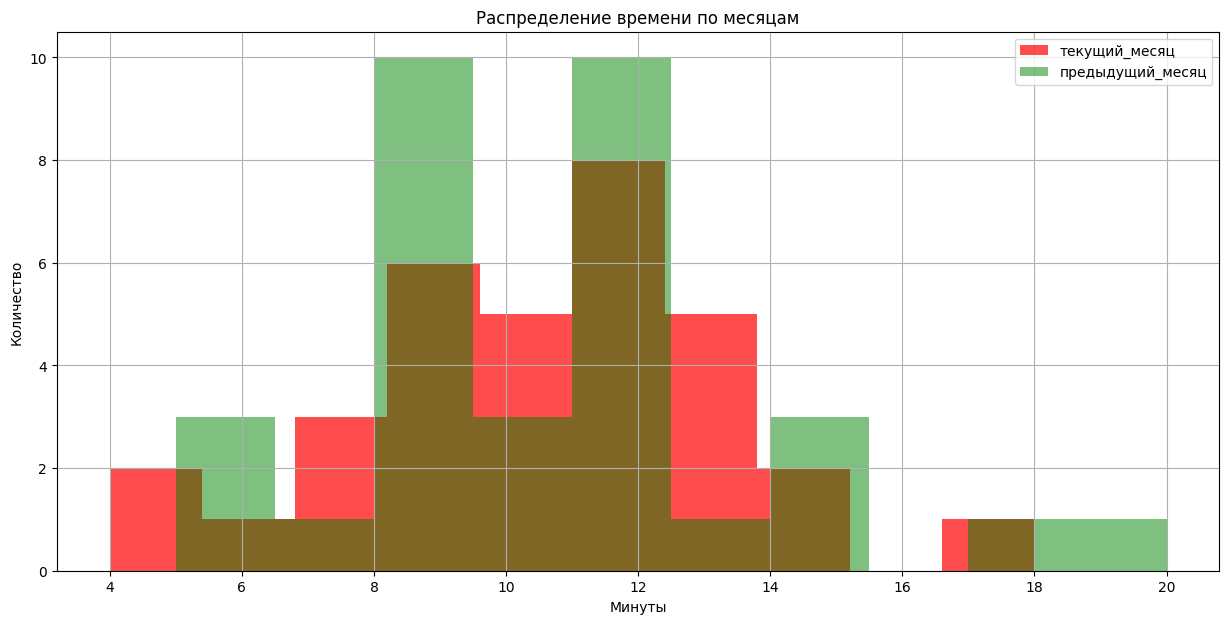

In [57]:
fig, ax = plt.subplots(figsize=(15,7))
segment['время_текущий_месяц'].hist(ax=ax, alpha=0.7, color='red')
segment['время_предыдущий_месяц'].hist(ax=ax, alpha=0.5, color='green')
lgnd = ax.legend(['текущий_месяц', 'предыдущий_месяц'], loc='upper right')
ax.set_xlabel('Минуты')
ax.set_ylabel('Количество')
ax.set_title('Распределение времени по месяцам')
plt.show;
display(segment['время_текущий_месяц'].describe())
display(segment['время_предыдущий_месяц'].describe())

В среднем пользователи проводят 10 минут на сайте, максимум 20 минут.

Мы проанализировали группу клиентов, которые покупают товары в основном только по акции и хранят товары в корзине, из сегмента с выручкой выше 2.4 и вероятностью снижения покупательской активности выше 0.6.

Мы узнали, что данная категория просматривает мало страниц за один раз. До семи, хотя в среднем пользователи просматривают восемь страниц. Изучают две-три категории товаров. Но при этом проводят не очень мало времени на сайте, изучая товары.

Самая популярная категория - "Детские товары". "Домашний текстиль" на втором месте.

Для поддержания покупательской активности данной категории клиентов можно предложить составить персональные предложения. Информацию о предложении пользователь должен видеть в корзине и на странице товара. Например, "вместе дешевле" (два товара из одной категории, которые дополняют друг друга). Можно вводить срочные акции на товары, которые долго лежат в корзине ("только сегодня можно купить со скидкой").

<a id='section_id9'></a>
## Вывод

Перед нами стояла задача разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Мы получили данные о 1300 клиентах (информация о поведении клиента на сайте, его финансовом и продуктовом поведении, о маркетинговом взаимодействии). Клиенты промаркированы по признаку "покупательская активность" (снизилась или осталась прежней).

На предобработке данных мы избавились от выбросов и удалили клиентов, которые не были активны три последних месяца. У нас осталось 1296 клиентов.

Мы провели анализ данных. Узнали, что:
 - 62% пользователей остаются на прежнем уровне покупательской активности
 - 71% пользуется стандартным типом сервиса
 - 74% разрешили сообщения
 - топ-3 популярных категорий: *Товары для детей*, *Домашний текстиль*, *Косметика и аксессуары*
 - в среднем происходит 4 маркетенговых контакта в месяц
 - в среднем пользователи зарегистрированы на сайте 600 дней
 - в среднем у клиентов 30% покупок по акции за последние полгода
 - в среднем за визит просматривают 3 категории и 8 страниц
 - среднее число сбоев сервиса - 4
 - за три месяца в среднем в корзине у клиентов лежит 3 неоплаченных товара
 - средняя выручка немного растет за последние три месяца, диапазон значений увеличивается
 - время нахождения на сайте в предыдущем и текущем месяцах приблизительно одинаково
 - мультиколлинеарности у признаков нет
 - покупательская активность зависит от времени, проведенном на сайте, и количества просмотренных страниц

На основе этих данный мы обучили модель, которая предсказывает снижение покупательской активности.

Для поиска лучшей модели мы использовали пайплайн и инструмент RandomizedSearchCV. RandomizedSearchCV проверил работу 20 моделей из 4 вариантов обучения, 3 вариантов стандартизации и различных гиперпараметров моделей и определил лучшую - SVC с метрикой ROC-AUC 90%.

Мы убедились, что важными признаками являются количество просмотренных страниц и время, проведенное на сайте.

Мы рассмотрели группу покупателей, которым модель предсказала снижение пользовательской активности с вероятностью более 0,6, прибыль от которых более 2,4, есть неоплаченные товары в корзине и предпочтение покупкам по акциям. Любимая категория - "Детские товары". Такие клиенты проводят достаточно времени на сайте, но просматривают немного страниц. Было сформулировано предложение по поддержанию их покупательской активности: срочные скидки на товары, которые долго лежат в корзине, и скидки на покупку комплекта. Предложения должны появляться в корзине и на страницах товаров, потому что мы выяснили, что сообщения, пуши и письма не влияют на потребительскую активность.